<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>Unit root and stationarity testing<span class="tocSkip"></span></h1> 

Using statsmodels for ADF and KPSS, and custom method for ADF, DF-GLS (based on sklearn).

To learn more about unit root testing, see the Regression Modeling Handbook at the bottom of: https://owlabs.atlassian.net/wiki/spaces/SQUADGAIA/overview

<h2>Table of Contents<span class="tocSkip"></span></h2>
<ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#statsmodels-methods" data-toc-modified-id="statsmodels-methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>statsmodels methods</a></span><ul class="toc-item"><li><span><a href="#Augmented-Dickey-Fuller" data-toc-modified-id="Augmented-Dickey-Fuller-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Augmented Dickey-Fuller</a></span></li><li><span><a href="#KPSS" data-toc-modified-id="KPSS-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>KPSS</a></span></li></ul></li><li><span><a href="#Custom-methods-for-ADF-and-DF-GLS" data-toc-modified-id="Custom-methods-for-ADF-and-DF-GLS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Custom methods for ADF and DF-GLS</a></span><ul class="toc-item"><li><span><a href="#Custom-ADF" data-toc-modified-id="Custom-ADF-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Custom ADF</a></span></li><li><span><a href="#Custom-DF-GLS" data-toc-modified-id="Custom-DF-GLS-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Custom DF-GLS</a></span></li></ul></li><li><span><a href="#Utility-for-multiple-tests-on-one-variable" data-toc-modified-id="Utility-for-multiple-tests-on-one-variable-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Utility for multiple tests on one variable</a></span></li><li><span><a href="#Utility-for-multiple-tests-on-multiple-variables" data-toc-modified-id="Utility-for-multiple-tests-on-multiple-variables-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Utility for multiple tests on multiple variables</a></span></li></ul>

In [1]:
# Import key libraries
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stattools
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

%load_ext autoreload
%autoreload 2

**Import code stored in the utilities folder**

In [2]:
import sys
sys.path.insert(0, "../../utilities")
from data_exploration import unit_root_testing

# Data

Here we generate some sample data for demonstration purposes.

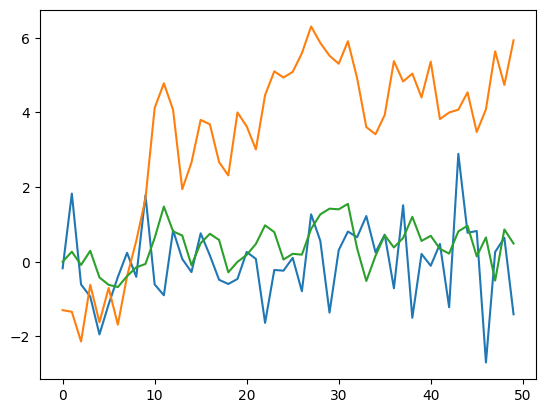

In [3]:
# Obtain sample data
size = 50
white_noise = np.random.randn(size)
plt.plot(white_noise)
random_walk = np.cumsum(np.random.randn(size))
plt.plot(random_walk)

temp_rand = np.random.randn(size)
rho = 0.8
ar_series = np.array([0.0 for i in range(0,size)])
ar_series[0] = 0
for i in range(1,size):
    ar_series[i] = ar_series[i-1]*rho + np.sqrt(1-np.power(rho,2))*temp_rand[i]
plt.plot(ar_series)
plt.show()

In [11]:
# Place data into a pandas DataFrame
ts_dataset = pd.DataFrame(data=np.transpose(np.array([white_noise, random_walk, ar_series])), columns=["noise", "random", "ar"])
ts_dataset.head()

,noise,random,ar
0,0.188574,-0.494507,0.000000
1,-0.875769,-0.759681,0.166474
2,1.779680,0.282005,-0.406074
3,-1.852767,0.807103,-0.152844
4,-1.547336,0.405845,0.235386


# statsmodels methods

We use statsmodels methods for two types of unit root / stationarity tests.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html

## Augmented Dickey-Fuller

In [12]:
results = []
for var in ts_dataset.columns:
    
    adf, pvalue, usedlag, nobs, _, _ = stattools.adfuller(ts_dataset[var], maxlag=None, regression='c', autolag='BIC')
    results.append(pd.DataFrame({
        "var":[var],
        "test":["ADF"],
        "lag":[usedlag],
        "statistic":[adf],
        "p-value":[pvalue]
    }))
    
pd.concat(results)

,var,test,lag,statistic,p-value
0,noise,ADF,0,-6.399714,2.009562e-08
0,random,ADF,0,1.001804,9.942849e-01
0,ar,ADF,0,-3.145305,2.337708e-02


## KPSS

In [13]:
results = []
for var in ts_dataset.columns:
    
    kpss, pvalue, lag, _ = stattools.kpss(ts_dataset[var], nlags=4, regression='c')
    results.append(pd.DataFrame({
        "var":[var],
        "test":["KPSS"],
        "lag":[lag],
        "statistic":[kpss],
        "p-value":[pvalue]
    }))
    
pd.concat(results)

,var,test,lag,statistic,p-value
0,noise,KPSS,4,0.095708,0.100000
0,random,KPSS,4,0.570237,0.025848
0,ar,KPSS,4,0.077560,0.100000


# Custom methods for ADF and DF-GLS

## Custom ADF

In [14]:
results = [unit_root_testing.ADF_test(ts_dataset, var_name, "trend", "Auto", "BIC") for var_name in ["noise", "random", "ar"]]

for i in range(0,3):
    print(["noise", "random", "ar"][i] + " dataset:\n")
    print("selected lag: " + str(results[i].lag) + "\n")
    print("t statistic: " + str(results[i].t_stat) + "\n")
    print("Critical Values: \n" + str(results[i].crit_vals) + "\n")
    print("Lag selection: \n" + str(results[i].lag_selection) + "\n\n\n")

noise dataset:

selected lag: 0

t statistic: -6.38474843877129

Critical Values: 
01%   -4.15
05%   -3.50
10%   -3.18
Name: 1, dtype: float64

Lag selection: 
BIC by lag {0: array([0.40268788]), 1: array([0.48392603]), 2: array([0.56329556]), 3: array([0.64635582])}



random dataset:

selected lag: 0

t statistic: -0.6287669669745161

Critical Values: 
01%   -4.15
05%   -3.50
10%   -3.18
Name: 1, dtype: float64

Lag selection: 
BIC by lag {0: array([0.10967446]), 1: array([0.17546459]), 2: array([0.25737337]), 3: array([0.33685936])}



ar dataset:

selected lag: 0

t statistic: -3.1090225065748522

Critical Values: 
01%   -4.15
05%   -3.50
10%   -3.18
Name: 1, dtype: float64

Lag selection: 
BIC by lag {0: array([-1.30414392]), 1: array([-1.22620473]), 2: array([-1.19441238]), 3: array([-1.11164662])}





## Custom DF-GLS

In [24]:
results = [unit_root_testing.DF_GLS_test(ts_dataset, var_name, "trend", "Auto", "MAIC") for var_name in ["noise", "random", "ar"]]

for i in range(0,3):
    print(["noise", "random", "ar"][i] + " dataset:\n")
    print("selected lag: " + str(results[i].lag) + "\n")
    print("t statistic: " + str(results[i].t_stat) + "\n")
    print("Critical Values: \n" + str(results[i].crit_vals) + "\n")
    print("Lag selection: \n" + str(results[i].lag_selection) + "\n\n\n")
    

noise dataset:

selected lag: 0

t statistic: -6.096880282746249

Critical Values: 
01%   -3.58
05%   -3.03
10%   -2.74
Name: 1, dtype: float64

Lag selection: 
MAIC by lag {0: (1.625823804421781, -5.855650335021331,     Vars      coef   std-err   t-stat         p-val
0  l1_yd -0.866761  0.148021 -5.85565  5.111847e-07), 1: (2.2088715497696616, -5.089398161801878,       Vars      coef   std-err    t-stat     p-val
0    l1_yd -1.005338  0.197536 -5.089398  0.000007
1  d_l1_yd  0.149463  0.150961  0.990078  0.327550), 2: (3.020951833920178, -4.7288329641535505,       Vars      coef   std-err    t-stat     p-val
0    l1_yd -1.154934  0.244232 -4.728833  0.000024
1  d_l1_yd  0.301275  0.200021  1.506217  0.139323
2  d_l2_yd  0.203838  0.153320  1.329497  0.190694), 3: (1.7077587001473593, -2.864437533312771,       Vars      coef   std-err    t-stat     p-val
0    l1_yd -0.829077  0.289438 -2.864438  0.006496
1  d_l1_yd  0.027758  0.236646  0.117297  0.907184
2  d_l2_yd -0.062117  0.196084 

# Utility for multiple tests on one variable

In [16]:
unit_root_testing.unit_root_test(data=ts_dataset, variable="random", tests=['ADF', 'KPSS', 'DF-GLS'], maxlag=['Auto'], type=['zero mean','mean'], adf_lag_selection=["BIC"], dfgls_lag_selection=['MAIC2'])

,var,test,type,max lag,lag_selection,lag,statistic,p-value
0,random,ADF,n,3.0,BIC,0,1.042837,0.921719
0,random,ADF,c,3.0,BIC,0,1.001804,0.994285
0,random,KPSS,c,NaN,N/A,3,0.684964,0.014912
0,random,DF-GLS,c,3.0,MAIC2,1,0.070038,>10%


# Utility for multiple tests on multiple variables

In [18]:
unit_root_testing.unit_root_test_wrapper(data=ts_dataset, variables=["random","noise","ar"], tests=['ADF', 'KPSS', 'DF-GLS'], maxlag=['Auto'], type=['zero mean','mean'], adf_lag_selection=["BIC"], dfgls_lag_selection=['MAIC2'])

,var,test,type,max lag,lag_selection,lag,statistic,p-value
0,random,ADF,n,3.0,BIC,0,1.042837,0.921719
1,random,ADF,c,3.0,BIC,0,1.001804,0.994285
2,random,KPSS,c,NaN,N/A,3,0.684964,0.014912
3,random,DF-GLS,c,3.0,MAIC2,1,0.070038,>10%
4,noise,ADF,n,3.0,BIC,0,-6.454563,0.0
5,noise,ADF,c,3.0,BIC,0,-6.399714,0.0
6,noise,KPSS,c,NaN,N/A,3,0.099623,>10%
7,noise,DF-GLS,c,3.0,MAIC2,2,-3.233862,<1%
8,ar,ADF,n,3.0,BIC,0,-3.176038,0.001493
9,ar,ADF,c,3.0,BIC,0,-3.145305,0.023377
